sv_times:
 [[0.0135539  0.02191757 0.02458751]
 [0.01876717 0.03384661 0.05079351]
 [0.0227221  0.04599321 0.07637445]]
qasm_times:
 [[0.01528427 0.02172386 0.02641217]
 [0.02153241 0.03773776 0.05470395]
 [0.0263102  0.05414692 0.09810781]]
sv - qasm:
 [[-0.00173037  0.00019371 -0.00182465]
 [-0.00276524 -0.00389115 -0.00391044]
 [-0.00358811 -0.0081537  -0.02173336]]


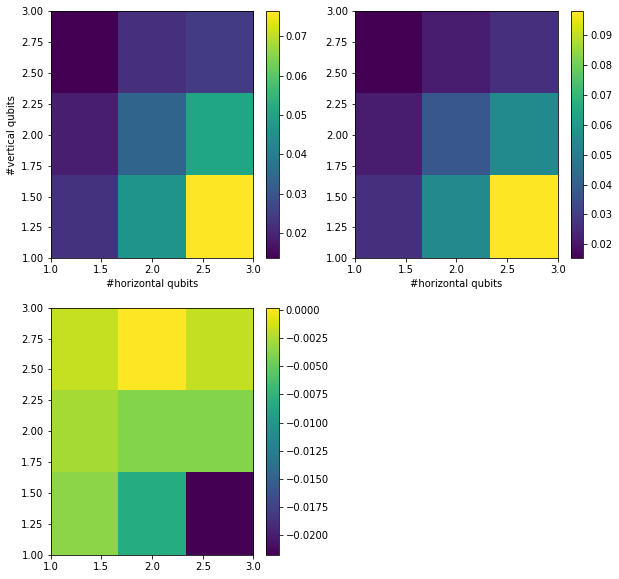

In [41]:
from qiskit.circuit.quantumregister import QuantumRegister
from qiskit.dagcircuit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.tools.visualization import dag_drawer
import supremacy_generator as suprem_gen
from qiskit import *
from qiskit.visualization import plot_state_city
import numpy as np
import functools
import timeit
from datetime import timedelta
import supremacy_generator as suprem_gen
import matplotlib.pyplot as plt
from matplotlib import cm

dimensions = range(1,4)
num_qubits = [x*x for x in dimensions]
sv_times = np.zeros((len(dimensions), len(dimensions)))
qasm_times = np.zeros((len(dimensions), len(dimensions)))
difference = np.zeros((len(dimensions), len(dimensions)))

for i in dimensions:
    for j in dimensions:
        if i*j<=24:
            circ = suprem_gen.circuit_generator(circuit_dimension=[i,j,8])

            sv_start = timeit.default_timer()
            backend = BasicAer.get_backend('statevector_simulator')
            job = execute(circ, backend)
            result = job.result()
            outputstate = result.get_statevector(circ)
            sv_outputprob = [np.power(abs(x),2) for x in outputstate]
            sv_end = timeit.default_timer()
            sv_times[i-1,j-1] = sv_end-sv_start

            qasm_start = timeit.default_timer()
            num_measurements = int(np.power(2,i*j))
            c = ClassicalRegister(i*j, 'c')
            meas = QuantumCircuit(circ.qregs[0], c)
            meas.barrier(circ.qubits)
            meas.measure(circ.qubits,c)
            qc = circ+meas

            backend_sim = BasicAer.get_backend('qasm_simulator')
            job_sim = execute(qc, backend_sim, shots=num_measurements)
            result_sim = job_sim.result()
            counts = result_sim.get_counts(qc)
            qasm_outputprob = [counts[x]/num_measurements for x in counts]
            qasm_end = timeit.default_timer()
            qasm_times[i-1,j-1] = qasm_end-qasm_start
            difference[i-1,j-1] = sv_times[i-1,j-1] - qasm_times[i-1,j-1]
        else:
            sv_times[i-1,j-1] = 0
            qasm_times[i-1,j-1] = 0
            difference[i-1,j-1] = sv_times[i-1,j-1] - qasm_times[i-1,j-1]

print('sv_times:\n', sv_times)
print('qasm_times:\n', qasm_times)
print('sv - qasm:\n', difference)

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(sv_times, aspect='auto',
           extent=[min(dimensions), max(dimensions), min(dimensions), max(dimensions)], cmap = cm.viridis)
plt.xlabel('#horizontal qubits')
plt.ylabel('#vertical qubits')
plt.colorbar()
plt.subplot(222)
plt.imshow(qasm_times, aspect='auto',
           extent=[min(dimensions), max(dimensions), min(dimensions), max(dimensions)], cmap = cm.viridis)
plt.colorbar()
plt.xlabel('#horizontal qubits')
plt.subplot(223)
plt.imshow(difference, aspect='auto',
           extent=[min(dimensions), max(dimensions), min(dimensions), max(dimensions)], cmap = cm.viridis)
plt.colorbar()
plt.show()

[('q[0]0,q[1]0', 'q[0]1,q[2]1'), ('q[0]0,q[1]0', 'q[1]1,q[3]1'), ('q[0]1,q[2]1', 'q[2]0,q[3]0'), ('q[1]1,q[3]1', 'q[2]0,q[3]0')]
will run 1 times
2


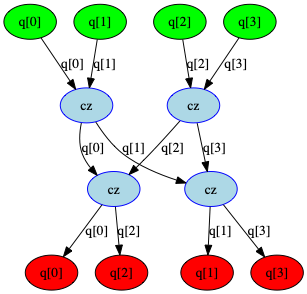

In [89]:
import min_cut as cut_finder

def find_neighbor(qarg, vert_info):
    for idx, (vertex_name, qargs) in enumerate(vert_info):
        if qarg in qargs:
            return vertex_name, True
    return None, False

def circ_stripping(circ):
    # Remove all single qubit gates in the circuit
    dag = circuit_to_dag(circ)
    stripped_dag = DAGCircuit()
    [stripped_dag.add_qreg(x) for x in circ.qregs]
    for vertex in dag.topological_op_nodes():
        if len(vertex.qargs) >= 2:
            stripped_dag.apply_operation_back(op=vertex.op, qargs=vertex.qargs)
    return dag_to_circuit(stripped_dag)

def circuit_to_graph(stripped_circ):
    input_qubit_itr = {}
    for x in stripped_circ.qubits:
        input_qubit_itr[x] = 0
    stripped_dag = circuit_to_dag(stripped_circ)
    vert_info = []
    for vertex in stripped_dag.topological_op_nodes():
        vertex_name = ''
        for qarg in vertex.qargs:
            if vertex_name == '':
                vertex_name += '%s[%d]%d' % (qarg[0].name,qarg[1],input_qubit_itr[qarg])
                input_qubit_itr[qarg] += 1
            else:
                vertex_name += ',%s[%d]%d' % (qarg[0].name,qarg[1],input_qubit_itr[qarg])
                input_qubit_itr[qarg] += 1
        vert_info.append((vertex_name, vertex.qargs))
    
    abstraction = []
    for idx, (vertex_name, vertex_qargs) in enumerate(vert_info):
        abstraction_item = [vertex_name]
        for qarg in vertex_qargs:
            prev_vertex_name, prev_found = find_neighbor(qarg, vert_info[:idx][::-1])
            next_vertex_name, next_found = find_neighbor(qarg, vert_info[idx+1:])
            if prev_found:
                abstraction_item.append(prev_vertex_name)
            if next_found:
                abstraction_item.append(next_vertex_name)
        abstraction.append(abstraction_item)
    graph = cut_finder.Graph(abstraction) 
    return graph

circ = suprem_gen.circuit_generator(circuit_dimension=[2,2,8])
stripped_circ = circ_stripping(circ)
graph = circuit_to_graph(stripped_circ)
# print(graph.verts)
print(graph.edges)
print(cut_finder.fast_min_cut(graph))
dag_drawer(circuit_to_dag(stripped_circ))